<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [19]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 100

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [20]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from google.colab import auth
auth.authenticate_user()

In [22]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [23]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [24]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,109129,Discharged,2188-08-01 12:04:00
1,121510,Discharged,2133-04-23 15:52:00
2,106469,Discharged,2109-02-23 12:01:00
3,133732,Discharged,2167-10-16 13:13:00
4,119601,Discharged,2198-02-20 15:33:00
...,...,...,...
230665,147635,Entered ICU,2124-11-22 21:55:59
230666,167802,Entered ICU,2200-02-26 18:40:12
230667,186391,Entered ICU,2134-01-08 21:59:39
230668,156213,Entered ICU,2107-02-05 17:16:52


## Section 2: Process Discovery

In [25]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-25-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36881, 'Transfer': 5716, 'Discharged': 55}
End events: {'Discharged': 34688, 'Left ICU': 7947, 'Transfer': 14, 'Admitted': 3}


In [26]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [27]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 29340
Number of events: 160233
Start events: {'Admitted': 29340}
End events: {'Discharged': 29340}


In [28]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

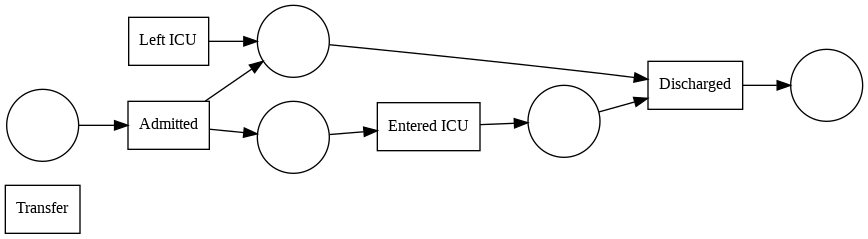

In [29]:
import graphviz
pm.view_petri_net(petri_net=net)

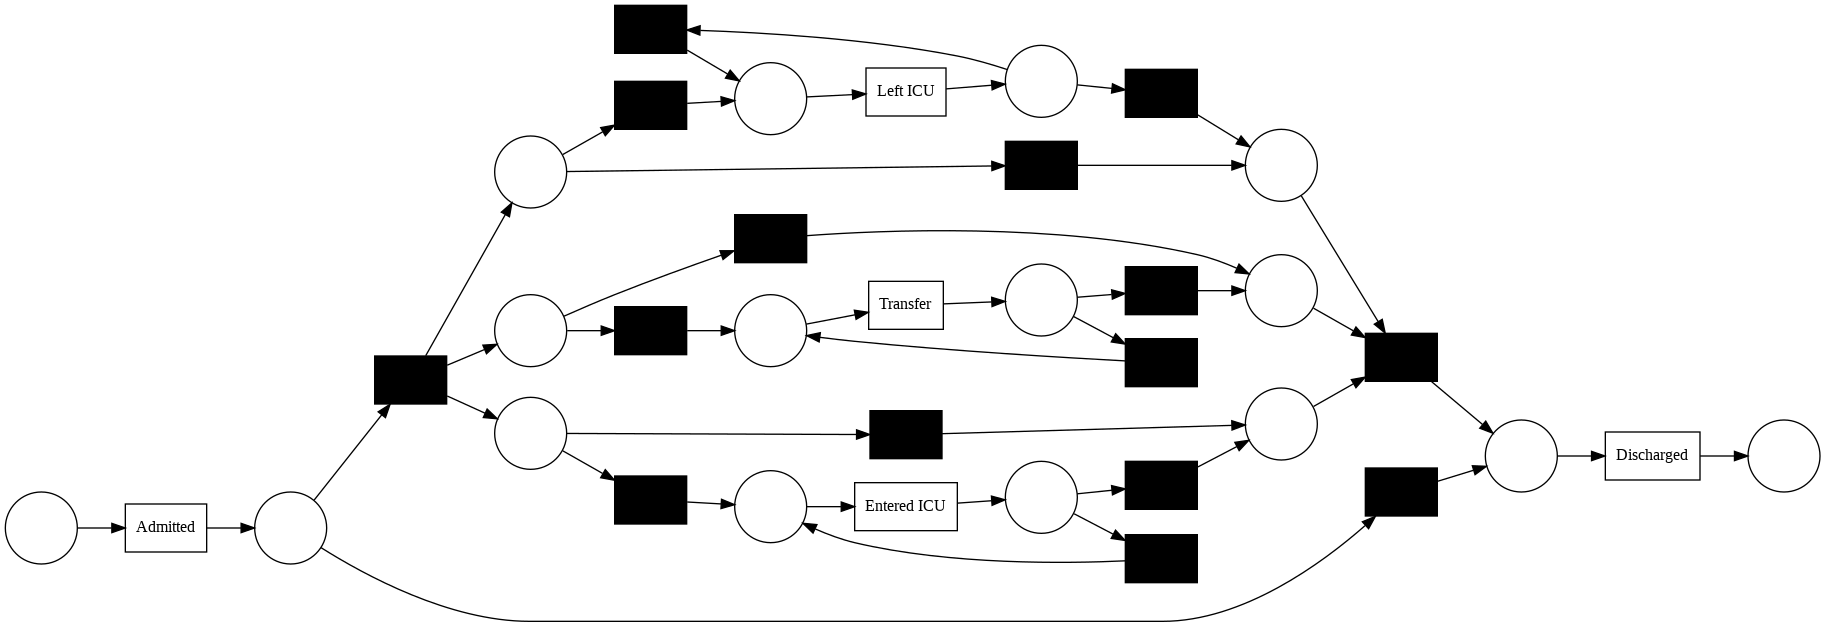

In [30]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

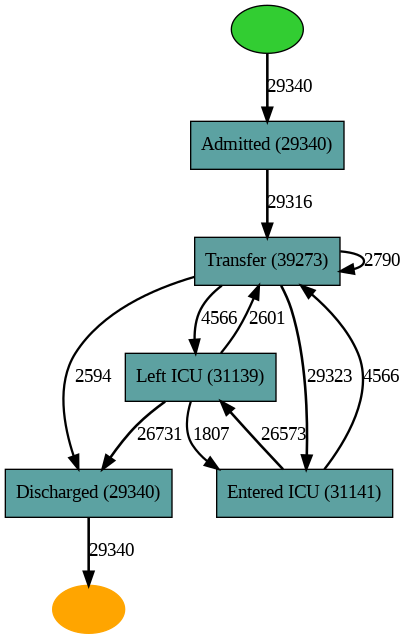

In [31]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

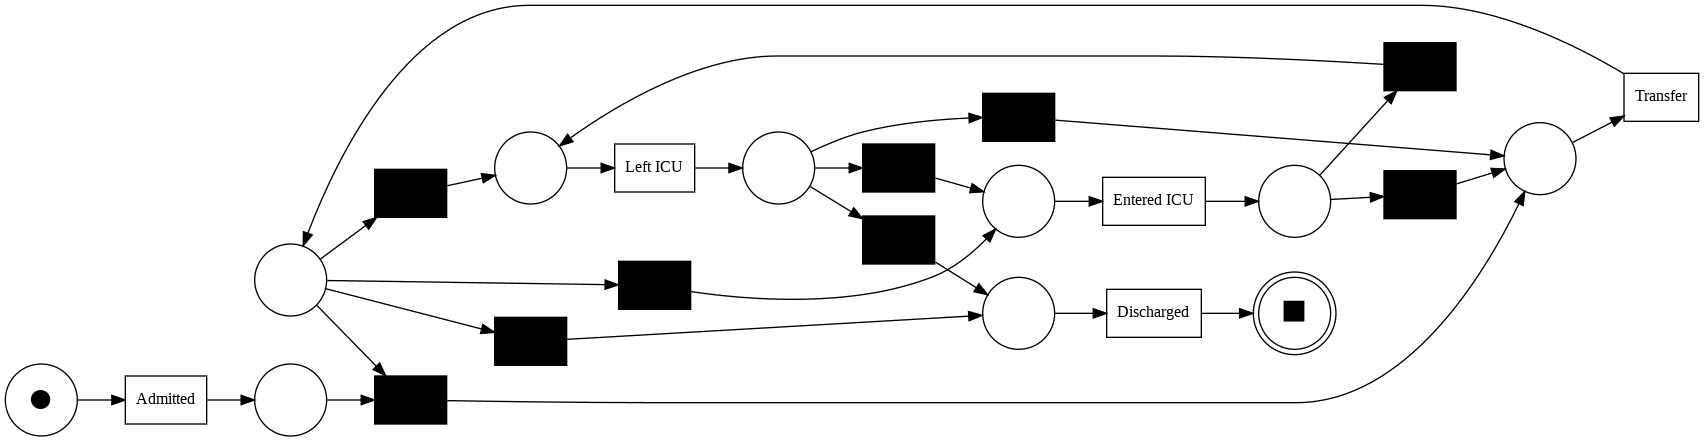

In [32]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

#Section 3: Preprocessing Data

In [38]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [39]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,trace,activity,timestamp
691,126,Admitted,2138-12-07 20:30:00
692,126,Transfer,2138-12-07 20:31:24
693,126,Entered ICU,2138-12-07 20:31:24
694,126,Left ICU,2138-12-10 01:02:45
695,126,Discharged,2138-12-10 18:51:00
...,...,...,...
160218,29337,Admitted,2188-07-07 18:47:00
160219,29337,Transfer,2188-07-07 18:49:00
160220,29337,Entered ICU,2188-07-07 18:49:00
160221,29337,Left ICU,2188-07-14 17:51:00


In [49]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
1490,270,Admitted,2187-01-03 12:26:00
1491,270,Transfer,2187-01-03 12:28:26
1492,270,Entered ICU,2187-01-03 12:28:26
1493,270,Left ICU,2187-01-13 16:10:04
1494,270,Discharged,2187-01-14 14:20:00
...,...,...,...
158623,29045,Admitted,2189-02-12 14:00:00
158624,29045,Transfer,2189-02-12 14:55:18
158625,29045,Entered ICU,2189-02-17 10:32:51
158626,29045,Left ICU,2189-02-18 19:04:57


In [66]:
import numpy as np

def random_remove(el):
  unique_traces_test = test_el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = test_el[:][test_el.trace == t]
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(0,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])

  return df, targets

(        trace     activity           timestamp
 1490      270     Admitted 2187-01-03 12:26:00
 1491      270     Transfer 2187-01-03 12:28:26
 1492      270  Entered ICU 2187-01-03 12:28:26
 1493      270     Left ICU 2187-01-13 16:10:04
 1494      270   Discharged                 NaT
 ...       ...          ...                 ...
 158623  29045     Admitted                 NaT
 158624  29045     Transfer 2189-02-12 14:55:18
 158625  29045  Entered ICU 2189-02-17 10:32:51
 158626  29045     Left ICU 2189-02-18 19:04:57
 158627  29045   Discharged 2189-02-21 16:20:00
 
 [108 rows x 3 columns],
 [Timestamp('2187-01-14 14:20:00'),
  Timestamp('2112-11-29 21:47:18'),
  Timestamp('2120-01-11 18:11:36'),
  Timestamp('2187-05-15 12:53:19'),
  Timestamp('2138-05-12 19:43:00'),
  Timestamp('2133-01-11 13:30:00'),
  Timestamp('2139-10-23 17:03:08'),
  Timestamp('2135-06-19 14:25:12'),
  Timestamp('2175-09-15 19:00:00'),
  Timestamp('2202-06-30 18:28:00'),
  Timestamp('2202-04-05 15:50:21'),
 

In [68]:
test_x, test_y = random_remove(test_el)
test_x

,trace,activity,timestamp
1490,270,Admitted,2187-01-03 12:26:00
1491,270,Transfer,NaT
1492,270,Entered ICU,2187-01-03 12:28:26
1493,270,Left ICU,2187-01-13 16:10:04
1494,270,Discharged,2187-01-14 14:20:00
...,...,...,...
158623,29045,Admitted,2189-02-12 14:00:00
158624,29045,Transfer,NaT
158625,29045,Entered ICU,2189-02-17 10:32:51
158626,29045,Left ICU,2189-02-18 19:04:57
